In [ ]:
!pip install yfinance arch statsmodels prophet --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 20.7 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

# display plots inline
%matplotlib inline


In [ ]:
prices = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False
)['Adj Close']



[*********************100%***********************]  3 of 3 completed


In [ ]:
prices.head()

Ticker,AAPL,MSFT,SPY
Date,,,
2020-01-02,72.620834,153.042282,299.406433
2020-01-03,71.914810,151.136642,297.139282
2020-01-06,72.487839,151.527313,298.272888
2020-01-07,72.146919,150.145706,297.434204
2020-01-08,73.307503,152.537277,299.019348


In [ ]:
# calculate daily simple returns
rets = prices.pct_change().dropna()

# portfolio return series
port_rets = rets.dot(weights)

# quick stationarity check (ADF test)
adf_p = adfuller(port_rets)[1]
print(f"ADF p-value: {adf_p:.3f}")


ADF p-value: 0.000


In [ ]:
# scale to percentages (arch expects non-tiny numbers)
port_rets_pct = port_rets * 100

# fit a GARCH(1,1) with constant mean
g = arch_model(port_rets_pct, vol='Garch', p=1, q=1, dist='normal')
res = g.fit(update_freq=5, disp='off')

# print a summary
print(res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2475.93
Distribution:                  Normal   AIC:                           4959.86
Method:            Maximum Likelihood   BIC:                           4980.78
                                        No. Observations:                 1378
Date:                Sat, Jul 05 2025   Df Residuals:                     1377
Time:                        06:55:26   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1068  3.779e-02      2.827  4.699e-03 [3.276e-0

In [ ]:
# 1-day ahead variance forecast
horizon = 1
fc = res.forecast(horizon=horizon)
var_forecast = fc.variance.values[-1, 0]        # variance in %²
sigma_forecast = np.sqrt(var_forecast) / 100    # convert back to decimal

print(f"Forecast σ (1-day): {sigma_forecast:.4%}")


Forecast σ (1-day): 0.9421%


In [ ]:
conf_level = 0.95

# -- Historical Simulation VaR
VaR_hist = -np.percentile(port_rets, (1 - conf_level) * 100)

# -- Monte Carlo VaR (normal sims using GARCH σ forecast)
n_sims = 10_000
sim_rets = np.random.normal(loc=port_rets.mean(),
                            scale=sigma_forecast,
                            size=n_sims)
VaR_mc = -np.percentile(sim_rets, (1 - conf_level) * 100)

print(f"Historical VaR @{conf_level*100:.0f}%: {VaR_hist:.2%}")
print(f"Monte Carlo VaR @{conf_level*100:.0f}%: {VaR_mc:.2%}")


Historical VaR @95%: 2.60%
Monte Carlo VaR @95%: 1.45%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuagrqao/73zrcxvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyuagrqao/bu7vwaua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20710', 'data', 'file=/tmp/tmpyuagrqao/73zrcxvr.json', 'init=/tmp/tmpyuagrqao/bu7vwaua.json', 'output', 'file=/tmp/tmpyuagrqao/prophet_modelgeq62hax/prophet_model-20250705065627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


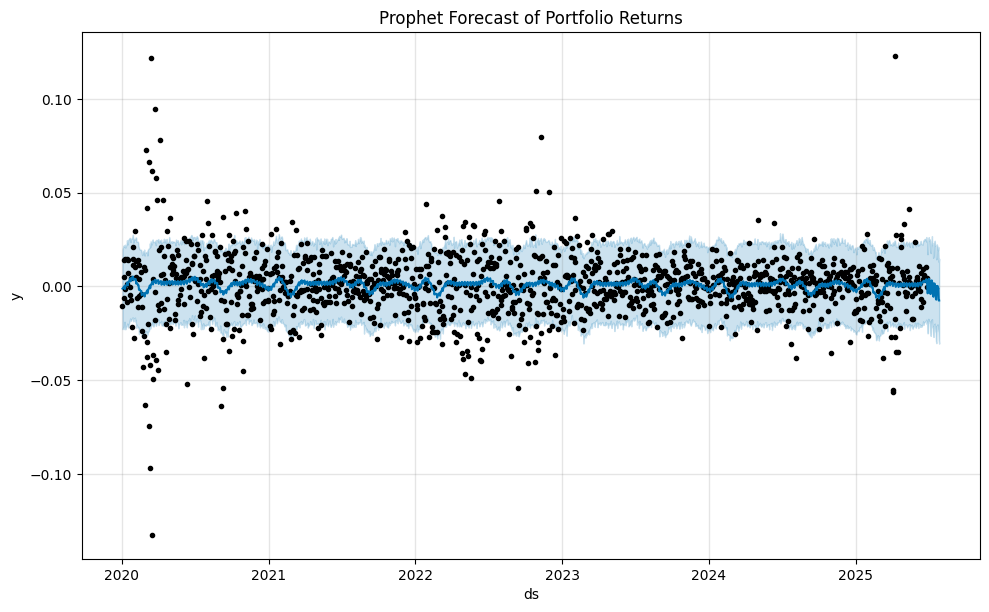

In [ ]:
df = port_rets.reset_index().rename(columns={'Date':'ds', 0:'y'})
m = Prophet(daily_seasonality=False, weekly_seasonality=True)
m.fit(df)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# plot forecast
fig1 = m.plot(forecast)
plt.title("Prophet Forecast of Portfolio Returns")
plt.show()


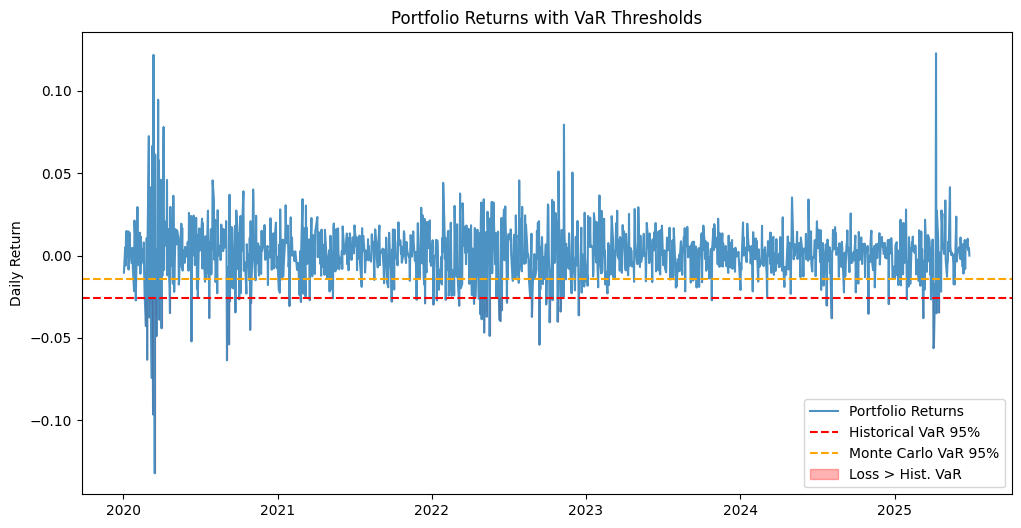

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(port_rets.index, port_rets, label='Portfolio Returns', alpha=0.8)

# horizontal lines for VaR
plt.axhline(-VaR_hist, color='red',   linestyle='--', label=f'Historical VaR {int(conf_level*100)}%')
plt.axhline(-VaR_mc,   color='orange', linestyle='--', label=f'Monte Carlo VaR {int(conf_level*100)}%')

# shade breaches
breach = port_rets < -VaR_hist
plt.fill_between(port_rets.index, port_rets, -VaR_hist,
                 where=breach, color='red', alpha=0.3,
                 label='Loss > Hist. VaR')

plt.title('Portfolio Returns with VaR Thresholds')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


In [ ]:
# 10.1 Build breach indicator
hist_VaR = np.percentile(port_rets, 5)   # 95% VaR: 5th percentile
breaches = port_rets < hist_VaR

# 10.2 Coverage
obs_rate = breaches.mean()
exp_rate = 0.05
print(f"Observed breach rate: {obs_rate:.3%}, Expected: {exp_rate:.3%}")

# 10.3 Kupiec POF test
from statsmodels.stats.proportion import proportions_ztest
count = breaches.sum()
nobs  = len(breaches)
stat, pval = proportions_ztest(count, nobs, exp_rate)
print(f"Kupiec POF p-value: {pval:.3f}")

# 10.4 Runs test for independence (Christoffersen)
from statsmodels.sandbox.stats.runs import runstest_1samp
# encode breaches as +1 (breach) / –1 (no breach)
runs_z, runs_p = runstest_1samp(breaches.astype(int)*2-1)
print(f"Runs test p-value: {runs_p:.3f}")


Observed breach rate: 5.007%, Expected: 5.000%
Kupiec POF p-value: 0.990
Runs test p-value: 0.148


In [ ]:
# 11.1 Historical ES
ES_hist = -port_rets[port_rets < -VaR_hist].mean()
print(f"Historical ES (95%): {ES_hist:.2%}")

# 11.2 Monte Carlo ES
tail_losses = sim_rets[sim_rets < -VaR_mc]
ES_mc = -tail_losses.mean()
print(f"MC ES (95%): {ES_mc:.2%}")


Historical ES (95%): 3.89%
MC ES (95%): 1.85%


In [ ]:
stress_dates = ('2008-09-01','2009-03-01')
stress_prices = prices.loc[stress_dates[0]:stress_dates[1]]
stress_rets   = stress_prices.pct_change().dropna().dot(weights)
stress_loss   = stress_rets.min()
print(f"Worst drawdown in stress period: {stress_loss:.2%}")


Worst drawdown in stress period: nan%


In [ ]:
# Example: GARCH-t
g_t = arch_model(port_rets_pct, vol='Garch', p=1, q=1, dist='t')
res_t = g_t.fit(disp='off')
print(res_t.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2446.70
Distribution:      Standardized Student's t   AIC:                           4903.40
Method:                  Maximum Likelihood   BIC:                           4929.54
                                              No. Observations:                 1378
Date:                      Sat, Jul 05 2025   Df Residuals:                     1377
Time:                              06:59:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        